# Assignment 2 – Evaluating LLM Output Quality

# Introduction to Large Language Models and Prompt Engineering

**Course:** GenAI development and LLM applications


**Instructors:** Ori Shapira, Yuval Belfer

**Semester:** Summer
    
## Overview

This assignment provides a **hands‑on** experince with the world of LLM based systems evaluation: from understanding the business use-case and defining evaluation criterias in light of it. To performing human evaluation and dealing with the hardships of "non-objectivity", trough experimenting with **JLMs** (Judge Language Models).

Along the way you will explore the differnces between the two evaluation methods, thier advanteges and dis-advanteges and try to figure out how and when to use each further down your GenAI road.

## Learning Objectives

- **Define evaluation criteria** understand the importance of defining how to measure your system performance in a non closely defined problem.
- **Compare** manual vs. automatic common methods.
- **Drive improvement** through proper evaluation, documentation and change cycles.
- **Design** usable automatic evaluation pipeline.

## Prerequisites
- Basic Python knowledge
- Familiarity with Jupyter notebooks
- Internet connection for API calls

# Part 1 - Human evaluation

## 1  Setup

In [1]:
!pip -q install --upgrade "transformers[torch]" datasets accelerate bitsandbytes --progress-bar off

## 2  Business use case – Generate Product Descriptions
Many e‑commerce sites need engaging **product descriptions**. Given structured attributes (name, category, features, color, price), your model should craft a persuasive, 50‑90‑word description.

In [6]:
# Load the product dataset
import pandas as pd

dataset_path = "csv_files/Assignment_02_product_dataset.csv"  # ensure the file is uploaded
df_products = pd.read_csv(dataset_path)
print(f"Loaded {len(df_products)} products")
df_products.head()

Loaded 50 products


,product_name,Product_attribute_list,material,warranty
0,Apple iPhone 15 Pro,"features: A17 Pro chip, 120 Hz ProMotion displ...","titanium frame, Ceramic Shield glass",1‑year limited warranty
1,Samsung Galaxy S24 Ultra,"features: 200 MP camera, S‑Pen support, 120 Hz...","Armor Aluminum frame, Gorilla Glass Victus",1‑year limited warranty
2,Google Pixel 8 Pro,"features: Tensor G3 chip, Magic Eraser, 50 MP ...","matte glass back, aluminum frame",1‑year limited warranty
3,Sony WH‑1000XM5 Headphones,"features: active noise cancelling, 30 hr batte...",synthetic leather earcups,1‑year limited warranty
4,Bose QuietComfort Ultra Earbuds,"features: CustomTune sound calibration, ANC, I...",silicone ear tips,1‑year limited warranty


## 3  Evaluation criteria
| Criterion | Description | Rating |
|-----------|-------------|--------|
| **Fluency** | Natural, easy‑to‑read sentences | good / ok / bad |
| **Grammar** | Correct spelling & punctuation | good / ok / bad |
| **Tone** | Matches friendly, credible sales voice | good / ok / bad |
| **Length** | 50‑90 words | good / ok / bad |
| **Grounding** | Sticks to provided attributes only | good / ok / bad |
| **Latency** | Time to first byte / full response | good / ok / bad  (based on avg. time per call)|
| **Cost** | Relative inference or API cost per 1K tokens | good / ok / bad (based on avg. price per cal)|

**Define your rubric:**
1. For each criterion, spell out what qualifies as **good**, **ok**, and **bad** to minimize subjectivity (e.g. for *Length*: good = 50‑90 words, ok = 40‑49 or 91‑110 words, bad = outside that range).
2. Decide the **cumulative pass bar**—for instance, at least three *good* ratings and no *bad* ratings overall.
3. Establish **go / no‑go rules**—e.g. if *Grounding* is *bad* the description is automatically rejected, regardless of other scores.

## 4  Prompt

💡 **Prompt‑engineering tip:**
Feel free to iterate on the prompt to maximize output quality. You can:
- Add a **system message** that defines writing style, brand voice, or formatting rules.
- Provide **one or two high‑quality examples** (few‑shot) of attribute→description pairs.
- Include explicit constraints (word count, tone adjectives, banned phrases).
- Experiment with phrases like *"Think step‑by‑step"* or *"First reason, then answer"*.

Document any changes you make and observe how they influence the evaluation scores.

In [8]:
prompt_tmpl = (
    "You are a copywriter for an online store. Using the product attributes, "
    "write an engaging product description (50–90 words).\n\n"
    "Product name: {product_name}\nFeatures: {Product_attribute_list}\nMaterial: {material}\nWarranty: {warranty}\n\n"
    "Description:"
)

## 5  Run a medium‑size model (≤ 30 B parameters)

Choose **one or more** of the options below:

**A. Hugging Face checkpoint** (local inference) – already configured in the code cell that follows.

**B. OpenAI model** – call an OpenAI hosted model (e.g. `gpt‑4o`, `gpt‑4‑turbo`, `gpt‑3.5‑turbo`). Implement `call_openai(prompt: str) -> str` in a separate utility cell and then run the snippet.

**C. Google Gemini model** – call a Gemini endpoint (e.g. `gemini‑1.5‑pro`). Implement `call_gemini(prompt: str) -> str` similarly.

> ⚠️ Make sure you have your API keys set as environment variables or passed securely.


**Latency & cost tracking**
- Your `call_*` functions should return a **dict** with keys:
  - `text` – generated description (string)
  - `latency_ms` – end‑to‑end generation time in milliseconds
  - `input_tokens` – tokens sent to the model (**IF YOU ADDED A SYS PROMPT ADD IT TO THE CALCULATION**)
  - `output_tokens` – tokens received from the model
- Below, a helper `call_hf()` shows how to compute these metrics for a Hugging Face model. You must add equivalent tracking inside `call_openai()` and `call_gemini()`.


**FOR COLAB USERS**

You can set your HF_TOKEN secret in Colab, please follow these steps:

1. Click on the "🔑" icon in the left-hand sidebar in Colab. This opens the Secrets manager.
2. Click on "New secret".
3. In the "Name" field, type HF_TOKEN.
4. In the "Value" field, paste your Hugging Face access token (you can generate one from your Hugging Face account settings under "Access Tokens").
5. Make sure the "Notebook access" toggle is enabled for your notebook.
6. Close the Secrets manager.

In [ ]:
# --- Option B: OpenAI ---
# Ensure you implemented call_openai() in another cell (you can use the one from the previous assignment).
# from your_utils import call_openai  # example import if needed
# response_oai = call_openai(prompt, model_name="gpt-4o")
# print(response_oai)

In [45]:
import google.generativeai as genai
import time

In [46]:
from dotenv import load_dotenv
import os

# Load the .env file
load_dotenv()

# Access variables
gemini_api_key = os.getenv("gemini_api_key")
openai_api_key = os.getenv("openai_api_key")

In [47]:
import time
from openai import OpenAI

def call_openai(prompt: str,
                model_name: str = "chatgpt-4o-latest",
                api_key: str = openai_api_key) -> dict:
    """
    Call OpenAI API (>=1.0) and return text + usage.
    """
    client = OpenAI(api_key=api_key) if api_key else OpenAI()

    start = time.time()
    try:
        resp = client.chat.completions.create(
            model=model_name,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7,
        )
        latency_ms = (time.time() - start) * 1000.0

        text = resp.choices[0].message.content or ""
        usage = getattr(resp, "usage", None)

        return {
            "text": text.strip(),
            "latency_ms": latency_ms,
            "input_tokens": getattr(usage, "input_tokens", None),
            "output_tokens": getattr(usage, "output_tokens", None),
            "total_tokens": getattr(usage, "total_tokens", None),
        }
    except Exception as e:
        print(f"OpenAI API Error: {e}")
        return {
            "text": "",
            "latency_ms": 0,
            "input_tokens": 0,
            "output_tokens": 0,
            "total_tokens": 0,
        }


In [48]:

# --- Option C: Gemini ---
def call_gemini(prompt: str, model_name: str = "models/gemini-1.5-pro", api_key: str = gemini_api_key) -> dict:
    """
    Call Google Gemini API and return generated text and usage metrics.

    Args:
        prompt (str): The user prompt.
        model_name (str): Gemini model to use (default: "gemini-pro").
        api_key (str): Google API Key.

    Returns:
        dict: {
            "text": generated description (str),
            "latency_ms": latency in milliseconds (float),
            "input_tokens": tokens sent (int),
            "output_tokens": tokens received (int)
        }
    """

    if not api_key:
        raise ValueError("api_key must be provided for Google Gemini API")

    genai.configure(api_key=api_key)

    # Initialize model
    model = genai.GenerativeModel(model_name)

    # Measure start time
    start_time = time.time()

    try:
        response = model.generate_content(prompt)
        end_time = time.time()
        latency_ms = (end_time - start_time) * 1000

        text = response.text.strip() if hasattr(response, "text") else ""

        # Token accounting (Gemini SDK does not expose usage directly yet)
        input_tokens = len(prompt.split())
        output_tokens = len(text.split())

        return {
            "text": text,
            "latency_ms": latency_ms,
            "input_tokens": input_tokens,
            "output_tokens": output_tokens
        }

    except Exception as e:
        print(f"Gemini API Error: {e}")
        return {
            "text": "",
            "latency_ms": 0,
            "input_tokens": 0,
            "output_tokens": 0
        }

In [49]:
# --- Batch generation helper (type‑safe) ---
from typing import Callable
import pandas as pd

from typing import Callable, Dict
import pandas as pd

def batch_generate(
    sample_df: pd.DataFrame,
    call_model_fn: Callable[[str], Dict[str, object]],
    prompt_template: str = prompt_tmpl,
) -> pd.DataFrame:
    """Generate descriptions and metrics for each row in *sample_df*.

    The model-calling function *must* return a dict with keys:
    - ``text`` (str) – generated description
    - ``latency_ms`` (float | None)
    - ``input_tokens`` (int | None)
    - ``output_tokens`` (int | None)
    """
    if not isinstance(sample_df, pd.DataFrame):
        raise TypeError("sample_df must be a pandas DataFrame")
    if not callable(call_model_fn):
        raise TypeError("call_model_fn must be callable")

    outputs = []
    for _, row in sample_df.iterrows():
        prompt = prompt_template.format(**row.to_dict())
        out = call_model_fn(prompt)
        if not isinstance(out, dict) or 'text' not in out:
            raise ValueError("call_model_fn must return a dict with at least a 'text' field")
        outputs.append(out)

    result_df = sample_df.copy()
    result_df["generated_description"] = [o["text"] for o in outputs]

    return result_df


demo_df = batch_generate(df_products[:5], call_openai)


## 6  Manual evaluation
Use `batch_generate()` to create a DataFrame of model outputs, then add blank rating columns for each criterion plus a `final_score` column. An Excel file is saved so you can fill scores offline or share with peers.

Steps:
1. Run the code cell below (adjust which `call_*` function you pass in).
2. Open the generated `assignment_03_evaluation_sheet.xlsx` and rate each row with **good / ok / bad**.
3. Add a rule for `final_score` (e.g., majority = good, fails if grounding = bad).


**Cost calculator**
Use the helper below to compute cost in USD based on token usage:
```python
outputs_df = add_cost_columns(outputs_df, input_price_per_m=1.5, output_price_per_m=2.0)
```
Set prices to **0** if you ran everything locally on Hugging Face.

In [58]:
# --- Build evaluation sheet & export to Excel ---

#Update the prices according to the model you used, or leave them at 0 for HF local models
YOUR_MODEL_INPUT_PRICE_PER_M = 1.25
YOUR_MODEL_OUTPUT_PRICE_PER_M = 5
outputs_df = batch_generate(df_products.head(), call_openai)  # NOTE: change model function as needed



## 7  Improvement cycle

Now that you’ve established a baseline score in **Section 6**, iterate to achieve better results.

**Ideas to explore**
- **Prompt tuning** – rewrite the system/user prompts, add few‑shot examples, or enforce stricter constraints.
- **Model choice** – test a different checkpoint (larger ≠ always better), switch from HF to OpenAI or Gemini, or try a domain‑specific model.
- **Temperature / decoding params** – adjust `temperature`, `top_p`, `top_k`, or `max_new_tokens` to balance creativity vs. factuality.
- **Data preprocessing** – clean attribute text, expand abbreviations, or group similar products to feed additional context.
- **Post‑processing** – run grammar‑checking or length trimming after generation.
- **Ensembling / RAG** – combine outputs from two models or ground the prompt with retrieved copy from existing catalog listings.

Document each experiment in a brief bullet list:
1. **What you changed**
2. **Why you expected it to help**
3. **New evaluation scores**

💡 *Goal*: maximize the cumulative score according to your rubric while respecting the go/no‑go rules.

# Part 2 – Judging Language Models (JLMs)

In Part 1 we generated model outputs and evaluated the outputs according to a set of business criterion.
Now we will build **JLMs** that (try really hard to match what you did and) automatically *grade* those outputs.

## 1 Naïve JLM (same model as generation)

For the product‑description task there is **no single reference answer**.  
Your naïve JLM should simply *critique the description itself* using the same
LLM that produced it.

* Inputs: the generated product description (string) and any rubric bullets you
  think matter (e.g. factual accuracy, persuasiveness, tone).  
* Output: **any useful signal** – free‑text comments, a JSON blob, a (score, notes) tuple… your choice.

> **Deliverable:** implement `naive_jlm(description)` that calls the LLM once and
> returns its raw judgment output.

In [59]:
judge_prompt_tmpl ="""
You are an expert evaluator of marketing copy. Based on the product information and the generated description below, evaluate the description using **only** these labels: "good", "ok", or "bad".

Rate each of the following categories:
- fluency
- grammar
- tone
- length (should be between 50–90 words)
- grounding (faithfulness to product attributes)
- latency (perceived delivery speed / verbosity)
- cost (efficiency of wording)
- final_score (overall quality)

**Product Details**
- Product name: {product_name}
- Key features: {Product_attribute_list}
- Material: {material}
- Warranty: {warranty}

**Generated Description**
{generated_description}

Return your evaluation in the following JSON format:

{{
  "fluency": "<good|ok|bad>",
  "grammar": "<good|ok|bad>",
  "tone": "<good|ok|bad>",
  "length": "<good|ok|bad>",
  "grounding": "<good|ok|bad>",
  "latency": "<good|ok|bad>",
  "cost": "<good|ok|bad>",
  "final_score": "<good|ok|bad>"
}}
"""


In [60]:
description = "Experience the pinnacle of innovation with the Apple iPhone 15 Pro.  Its powerful A17 Pro chip fuels a breathtaking 120Hz ProMotion display for incredibly smooth visuals.  The durable titanium frame and Ceramic Shield glass encase this compact powerhouse. Enjoy blazing-fast charging with USB-C. Comes with a 1-year limited warranty for peace of mind. Upgrade to pro."

In [62]:
# ------------------------- STUDENT TODO -------------------------
# Implement a simple self‑critique using the SAME model used for generation.
# No reference answer is available, so evaluate the description directly.

# IMPORTANT NOTE :use the same model as the one you used for generation
def naive_jlm(description: str):
    """Return a naive judgment (format of your choice) for a product description."""
    # Example pseudocode:
    prompt = """You are a product‑description critic. Evaluate the following description
     on clarity, appeal, and accuracy. Return JSON with 'strengths', 'weaknesses',
     and an overall 'rating' from 1‑5.\n\nDescription:\n{description}\nJSON:"""
    
    response = call_openai(prompt.format(description=description))["text"]
    return response


In [73]:
naive_out = naive_jlm(description)

In [64]:
import json

In [75]:
json.loads(naive_out)

{'strengths': ['Clear mention of key features such as the A17 Pro chip, 120Hz ProMotion display, and USB-C charging',
  "Appealing language like 'pinnacle of innovation' and 'compact powerhouse' enhances product desirability",
  'Brief but informative—covers hardware, performance, durability, and warranty',
  'Mentions the premium build materials (titanium frame, Ceramic Shield), which adds credibility and luxury appeal'],
 'weaknesses': ['Lacks specific technical details such as screen size, battery life, or camera specifications, which could help with informed decision-making',
  "Phrases like 'blazing-fast charging' are vague and could be supported with numbers (e.g., wattage or charging time)",
  "The phrase 'Upgrade to pro' is somewhat generic and doesn’t add meaningful information"],
 'rating': 4}

## 2 Structured JLM – JSON per criterion

We want our grader to return **machine‑readable JSON** so that we can later **automate
aggregate scoring and analysis** (e.g., Section 5 majority vote, dashboards, or batch
experiments).

For every evaluation criterion you defined in Part 1 sectoin 3, output an object that looks
like this (keys must match your own criteria list):

* **Fluency**  
* **Grammar**  
* **Tone**  
* **Length**  
* **Grounding**  (e.g. factual alignment / no hallucinations)

We will grade every description on the **criteria** we care about for this
assignment:
```json
{
  "Fluency":   {"explanation": "...", "verdict": "good"},
  "Grammar":   {"explanation": "...", "verdict": "ok"},
  "Tone":      {"explanation": "...", "verdict": "good"},
  "Length":    {"explanation": "...", "verdict": "good"},
  "Grounding": {"explanation": "...", "verdict": "good"},
}
```


*\*The following will be ignored for convinence and as they do not require JLM*
* **Latency**
* **Cost**




### Why `{explanation, verdict}`?

1. **Justification before decision** – forcing the model to produce an *explanation*
   **first** encourages reasoned thinking; if it wrote the verdict first, the
   explanation might simply try to defend that label (confirmation bias).  
2. **Auditability** – having a short explanation lets us *spot‑check* the grader
   for hallucinations or mis‑interpretations down the line.  
3. **Closed‑class verdicts** – restricting the verdict to a small set
   (`good | ok | bad`) enables fast, deterministic score calculations in later
   automated pipelines.

### Your implementation

* **Backend choice:** `call_openai()`, `call_gemini()`, `call_hf()`, or a
  LangChain chat model – choose whatever you prefer.  
* **Prompt freedom:** use the template we provide *or rewrite it entirely*.  
* Loop over the global `criteria` list from Part 1 §3.  
* Implement **`structured_jlm(description)`** so the cell runs without errors and
  returns the parsed JSON.

In [76]:
# ------------------------- STUDENT TODO -------------------------
import json

# Fixed criteria list for the assignment
criteria = ["Fluency", "Grammar", "Tone", "Length", "Grounding"]

# Choose backend: "openai", "gemini", "hf"
BACKEND = "openai"

# Prompt template (edit freely)
PROMPT_TEMPLATE = """You are a product‑description critic.
For each criterion in the list below, provide a JSON object with:
  • explanation (1‑2 sentences)
  • verdict      (good | ok | bad)

Criteria: {criteria}

Description:
{description}

JSON:"""

#IMPORTANT NOTE :use the same model as the one you used for generation
def call_model(prompt: str, model_name: str) -> str:
    if BACKEND == "openai":
        return call_openai(prompt, model_name)["text"]
    elif BACKEND == "gemini":
        return call_gemini(prompt, model_name)
    elif BACKEND == "hf":
        return call_hf(prompt, model_name)

def structured_jlm(description: str, model_name:str) -> dict:
    prompt = PROMPT_TEMPLATE.format(criteria=", ".join(criteria),
                                    description=description)
    raw = call_model(prompt, model_name) # NOTICE this is the raw response, modify it as you will to make the next step work

    try: #NOTE: Making sure your model returns a valid JSON object is sometimes harder than you think...
        return json.loads(raw)
    except json.JSONDecodeError:
        raise ValueError(f"Error: Invalid JSON response from model: {raw}")

# ---------------------------------------------------------------

structured_out = structured_jlm(description, model_name="chatgpt-4o-latest")

In [78]:
structured_out

{'Fluency': {'explanation': 'The description reads smoothly and logically, with a coherent flow between features and benefits.',
  'verdict': 'good'},
 'Grammar': {'explanation': 'There are no grammatical errors; punctuation and sentence structure are correct throughout.',
  'verdict': 'good'},
 'Tone': {'explanation': 'The tone is enthusiastic and promotional, well-suited for a high-end tech product like the iPhone 15 Pro.',
  'verdict': 'good'},
 'Length': {'explanation': 'The description is concise while covering key features, making it well-suited for online retail or marketing contexts.',
  'verdict': 'good'},
 'Grounding': {'explanation': 'All claims are consistent with known specifications of the iPhone 15 Pro, such as the A17 Pro chip and USB-C charging.',
  'verdict': 'good'}}

## 3 Criterion‑by‑Criterion Calls

Instead of asking the JLM to grade *all* criteria in one big prompt, we can
make **one call per criterion** and merge the results.

### Why split?

1. **Sharper focus ⇢ better judgments**  
   The model concentrates on a *single* dimension at a time, which often boosts
   accuracy – atomic tasks are easier.  
2. **Richer, criterion‑specific instructions**  
   You can craft a longer, more detailed prompt for *each* criterion without
   squeezing everything into one context window.

### Trade‑offs

1. **Higher cost** – `#criteria × price‑per‑call` can add up.  
2. **Higher latency** – multiple sequential calls take longer than one.



### Your task

1. Implement **`per_criterion_jlm(description)`** (see code cell below) using any backend (`call_openai`, `call_gemini`, `call_hf`, or `jlm_llm`).
2. **Pick one generated product description** and run **all three graders**:
   * `naive_jlm(description)` (Section 1)
   * `structured_jlm(description)` (Section 2)
   * `per_criterion_jlm(description)` (this section)
3. Compare the outputs. Note any differences in explanations and verdicts.

Write two‑three sentences of reflection in the markdown cell that follows: *Which approach seems most trustworthy for this task and why?*

In [70]:
import json

criteria = ["Fluency", "Grammar", "Tone", "Length", "Grounding"]

# Re‑use BACKEND and call_model() from Section 2, or redefine here.
try:
    BACKEND
except NameError:
    BACKEND = "hf"  # fallback; set to openai / gemini / hf as needed

# If call_model is not defined (e.g., you skipped Section 2), define a minimal version
if "call_model" not in globals():
    def call_model(prompt: str, model_name: str) -> str:
        if BACKEND == "openai":
            return call_openai(prompt, model_name)
        elif BACKEND == "gemini":
            return call_gemini(prompt, model_name)
        elif BACKEND == "hf":
            return call_hf(prompt, model_name)

# Template per criterion (modify as you like)
CRIT_PROMPT_TEMPLATE = """You are a product‑description critic.
Criterion: {criterion}
Return JSON with keys 'explanation' and 'verdict' (good|ok|bad).

Description:
{description}

JSON:"""

#IMPORTANT NOTE :use the same model as the one you used for generation
def per_criterion_jlm(description: str, model_name: str, criteria: list[str] | None = None) -> dict:
    """Grade *description* against each criterion in *criteria* with separate LLM calls.

    Parameters
    ----------
    description : str
        Product description to evaluate.
    criteria : list[str], optional
        List of evaluation criteria. If *None*, falls back to the global ``criteria`` list
        defined in this notebook.
    Returns
    -------
    dict
        Mapping from criterion name to the parsed JSON returned by the judge‑LLM.
    """
    if criteria is None:
        # Use the global variable if available; otherwise default to common criteria.
        criteria = globals().get("criteria", ["Fluency", "Grammar", "Tone", "Length", "Grounding"])

    results = {}
    for crit in criteria:
        prompt = CRIT_PROMPT_TEMPLATE.format(criterion=crit, description=description)
        raw = call_model(prompt, model_name)
        try:
            results[crit] = json.loads(raw)
        except json.JSONDecodeError:
            raise ValueError(f"Error parsing JSON for criterion {crit}: {raw}")

    return results

In [71]:
results = per_criterion_jlm(description,"chatgpt-4o-latest", criteria)

In [ ]:
results

{'Fluency': {'explanation': 'The product description is fluent and well-structured, with clear and grammatically correct sentences. It uses varied sentence structures and transitions smoothly between features. The vocabulary is appropriate and engaging, enhancing the overall readability and promotional tone.',
  'verdict': 'good'},
 'Grammar': {'explanation': "The grammar in the product description is strong overall. Sentences are well-structured, punctuation is used correctly, and there are no spelling or subject-verb agreement issues. Minor style improvements could be made, such as avoiding sentence fragments like 'Comes with a 1-year limited warranty for peace of mind,' which lacks a clear subject. However, this is acceptable in marketing copy.",
  'verdict': 'good'},
 'Tone': {'explanation': "The tone of the product description is confident, sleek, and aspirational—well-suited for a premium tech product like the iPhone 15 Pro. It uses enthusiastic and descriptive language such as '

The per-criterion grader felt most trustworthy: judging one dimension at a time produced clearer, actionable explanations and caught nuances (e.g., Length/Grounding) that the single-shot graders glossed over. The structured grader was solid but noticeably more lenient, while the naive grader tended to be generous and less specific. Despite the extra calls (cost/latency), the per-criterion approach gives better transparency and debuggability for this task.

## 4 Different Model JLM

### Why switch models?

We **do not reuse the generator model as the judge** because:

1. **Self‑evaluation bias** – a model tends to justify its own outputs, consciously or not, and can over‑score itself.  
2. **Correlated failure modes** – the generator’s blind‑spots (hallucinations, sloppy reasoning) may also appear in its judgments.  
3. **Diversity of signal** – using an *independent* model (preferably from another provider) gives a more reliable second opinion.

### Your task

* Pick a **different provider** than you used in Sections 1‑3 (e.g. if you relied on OpenAI, try Gemini or Claude; if you used HF, try OpenAI, etc.).  
* Implement **`per_criterion_jlm_alt()`** – a thin wrapper that calls `per_criterion_jlm()` *after temporarily switching* the backend to this alternate provider, so it still returns the usual `{explanation, verdict}` JSON for **each criterion**.  
  * You may use helpers such as `call_openai`, `call_gemini`, `call_hf`, or any LangChain chat model—your choice.  
  * Feel free to craft a new prompt tailored to the provider.  

### Compare

Run both graders – **Section 3’s `per_criterion_jlm()`** and the new **`per_criterion_jlm_alt()`** – on the *same* product description:

* Are the verdicts identical?  
* Does the new JLM appear to **favour or penalise** the generated answer differently?  
* Add a brief reflection in the markdown cell that follows.


In [85]:
BACKEND = "gemini"

In [89]:
import json

criteria = ["Fluency", "Grammar", "Tone", "Length", "Grounding"]

# Re‑use BACKEND and call_model() from Section 2, or redefine here.
try:
    BACKEND
except NameError:
    BACKEND = "hf"  # fallback; set to openai / gemini / hf as needed

# If call_model is not defined (e.g., you skipped Section 2), define a minimal version
if "call_model" not in globals():
    def call_model(prompt: str, model_name: str) -> str:
        if BACKEND == "openai":
            return call_openai(prompt, model_name)
        elif BACKEND == "gemini":
            return call_gemini(prompt, model_name)
        elif BACKEND == "hf":
            return call_hf(prompt, model_name)

# Template per criterion (modify as you like)
CRIT_PROMPT_TEMPLATE = """You are a product‑description critic.
Criterion: {criterion}
Return JSON with keys 'explanation' and 'verdict' (good|ok|bad).

Description:
{description}

JSON:"""

# IMPORTANT NOTE: use the same model you used for generation
def per_criterion_jlm(description: str, model_name: str, criteria: list[str] | None = None) -> dict:
    """
    Grade *description* against each criterion in *criteria* with separate LLM calls.
    Works with Gemini / OpenAI / HF. Robust to fenced JSON (```json ... ```).
    """
    import re, json

    if criteria is None:
        criteria = globals().get("criteria", ["Fluency", "Grammar", "Tone", "Length", "Grounding"])

    # --- helpers (local so the rest of your notebook stays unchanged) ---
    def _first_json_object(s: str) -> str | None:
        s = str(s)
        start = s.find("{")
        if start == -1:
            return None
        depth = 0
        for i in range(start, len(s)):
            c = s[i]
            if c == "{":
                depth += 1
            elif c == "}":
                depth -= 1
                if depth == 0:
                    return s[start:i+1]
        return None

    def _clean_llm_json_text(text: str) -> str:
        """Strip code fences and extra prose; return just the JSON object if found."""
        s = str(text).strip()
        if s.startswith("```"):
            s = re.sub(r"^```[a-zA-Z0-9_-]*\s*", "", s)
            s = re.sub(r"\s*```$", "", s)
        obj = _first_json_object(s)
        return obj if obj is not None else s

    results = {}
    for crit in criteria:
        prompt = CRIT_PROMPT_TEMPLATE.format(criterion=crit, description=description)

        # Your call_model may return dict ({"text": ...}) or plain string; normalize to text
        out = call_model(prompt, model_name)
        text = out.get("text", "") if isinstance(out, dict) else out

        # Clean up Gemini-style fenced JSON (and any extra prose) before parsing
        text = _clean_llm_json_text(text)

        try:
            results[crit] = json.loads(text)
        except json.JSONDecodeError:
            raise ValueError(f"Error parsing JSON for criterion {crit}: {text}")

    return results


In [90]:
results = per_criterion_jlm(description,"gemini-1.5-pro", criteria)

In [23]:
results

{'Fluency': {'text': '```json\n{\n  "explanation": "The description is fluent and easy to read.  The language used is appropriate for marketing an Apple product, employing persuasive vocabulary like \\"pinnacle of innovation,\\" \\"breathtaking,\\" and \\"blazing-fast.\\"  The sentence structure is varied, avoiding monotony.  There is a clear progression of features.",\n  "verdict": "good"\n}\n```',
  'latency_ms': 3942.1138763427734,
  'input_tokens': 73,
  'output_tokens': 49},
 'Grammar': {'text': '```json\n{\n  "explanation": "The grammar in the product description is excellent.  All sentences are correctly structured, the punctuation is accurate, and the language is clear and concise. There are no grammatical errors.",\n  "verdict": "good"\n}\n```',
  'latency_ms': 3587.919235229492,
  'input_tokens': 73,
  'output_tokens': 36},
 'Tone': {'text': '```json\n{\n  "explanation": "The tone is overly enthusiastic and uses marketing hype (\'pinnacle of innovation\', \'breathtaking\', \'

## 5 Creating a Dataset‑Evaluation Infrastructure

You now have several JLM graders (`structured_jlm`, `per_criterion_jlm` and `naive_jlm`) that can judge a *single* product description.  
The next step is to **scale that evaluation to an entire dataset** of model outputs so you can compute corpus‑level metrics and quickly spot problematic cases.

### Why build an infrastructure?

* **Reproducibility & tracking** – running all descriptions through the *same* grading pipeline lets you store the verdict/explanation alongside the raw generations for future audits.  
* **Bulk analytics** – with judgments in a DataFrame you can compute pass‑rates, per‑criterion confusion matrices, or slice‑by‑slice performance (e.g., electronics vs. clothing).  
* **Error triage** – the explanation text helps you cluster or search for recurring failure modes (e.g., "missing dimensions", "over‑hyping").  
* **Continuous evaluation** – once scripted, you can rerun the notebook after each model iteration and track deltas automatically.

### What to implement

1. **Iterate over the dataset** – a `pandas.DataFrame` where each row has at least a `description` column (and optionally metadata like `product_id`, `category`).  
2. **Apply your chosen grader** – call **one** of your JLM functions (`per_criterion_jlm` is a good default) per row.  
3. **Add columns** – for every evaluation criterion create `<criterion>_explanation` and `<criterion>_verdict` columns.  
4. **Save or return the enriched DataFrame** so you can inspect it, compute stats, or export to CSV/Parquet.

A starter helper function is provided in the code cell below—customise it as needed.

In [91]:
outputs_df

,product_name,Product_attribute_list,material,warranty,generated_description
0,Apple iPhone 15 Pro,"features: A17 Pro chip, 120 Hz ProMotion displ...","titanium frame, Ceramic Shield glass",1‑year limited warranty,Unleash next-level performance with the Apple ...
1,Samsung Galaxy S24 Ultra,"features: 200 MP camera, S‑Pen support, 120 Hz...","Armor Aluminum frame, Gorilla Glass Victus",1‑year limited warranty,Unleash the extraordinary with the Samsung Gal...
2,Google Pixel 8 Pro,"features: Tensor G3 chip, Magic Eraser, 50 MP ...","matte glass back, aluminum frame",1‑year limited warranty,Meet the Google Pixel 8 Pro — the smartphone e...
3,Sony WH‑1000XM5 Headphones,"features: active noise cancelling, 30 hr batte...",synthetic leather earcups,1‑year limited warranty,Immerse yourself in pure sound with the Sony W...
4,Bose QuietComfort Ultra Earbuds,"features: CustomTune sound calibration, ANC, I...",silicone ear tips,1‑year limited warranty,Experience audio like never before with the Bo...


In [93]:
# ------------------------- STUDENT TODO -------------------------
# Iterate over a DataFrame of product descriptions, run alt_jlm on each row,
# and append explanation & verdict columns per criterion.
#
# Expected input format:
#   df["description"]  -> the text to judge
#
# Example output columns for criterion 'clarity':
#   clarity_explanation , clarity_verdict
#
# Adjust variable names / saving as needed.

import pandas as pd

def judge_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    judged_rows = []
    for _, row in df.iterrows():
        desc = row["generated_description"]
        result = per_criterion_jlm(desc, "gemini-1.5-pro", criteria)  # {crit: {"explanation": ..., "verdict": ...}}
        flat = row.to_dict()
        for crit, vals in result.items():
            flat[f"{crit}_explanation"] = vals["explanation"]
            flat[f"{crit}_verdict"] = vals["verdict"]
        judged_rows.append(flat)
    return pd.DataFrame(judged_rows)

# Example usage:

df_scored = judge_dataframe(outputs_df)
df_scored.to_csv("descriptions_with_judgments.csv", index=False)
df_scored.head()
# ---------------------------------------------------------------


,product_name,Product_attribute_list,material,warranty,generated_description,Fluency_explanation,Fluency_verdict,Grammar_explanation,Grammar_verdict,Tone_explanation,Tone_verdict,Length_explanation,Length_verdict,Grounding_explanation,Grounding_verdict
0,Apple iPhone 15 Pro,"features: A17 Pro chip, 120 Hz ProMotion displ...","titanium frame, Ceramic Shield glass",1‑year limited warranty,Unleash next-level performance with the Apple ...,The description flows well and is easy to unde...,good,The grammar in this description is excellent. ...,good,"The tone is professional and enthusiastic, hig...",good,This description is a good length. It highligh...,good,The description provides specific details that...,good
1,Samsung Galaxy S24 Ultra,"features: 200 MP camera, S‑Pen support, 120 Hz...","Armor Aluminum frame, Gorilla Glass Victus",1‑year limited warranty,Unleash the extraordinary with the Samsung Gal...,"The description flows well, using strong verbs...",good,The grammar in this description is excellent. ...,good,"The tone is sophisticated and enthusiastic, ef...",good,This description is a good length. It highligh...,good,The description provides specific details abou...,good
2,Google Pixel 8 Pro,"features: Tensor G3 chip, Magic Eraser, 50 MP ...","matte glass back, aluminum frame",1‑year limited warranty,Meet the Google Pixel 8 Pro — the smartphone e...,The description flows well and is easy to unde...,good,The grammar in this description is excellent. ...,good,"The tone is positive and enthusiastic, highlig...",good,This description is concise and effectively hi...,good,The description provides specific details like...,good
3,Sony WH‑1000XM5 Headphones,"features: active noise cancelling, 30 hr batte...",synthetic leather earcups,1‑year limited warranty,Immerse yourself in pure sound with the Sony W...,The description flows well and is easy to unde...,good,The grammar in this description is excellent. ...,good,The tone is slightly elevated and sophisticate...,good,This description is a good length. It provides...,good,The description provides specific details that...,good
4,Bose QuietComfort Ultra Earbuds,"features: CustomTune sound calibration, ANC, I...",silicone ear tips,1‑year limited warranty,Experience audio like never before with the Bo...,The description flows well and is easy to unde...,good,The grammar in this description is excellent. ...,good,"The tone is positive and enthusiastic, highlig...",good,This description is a good length. It provides...,good,The description provides specific features tha...,ok




You now have a DataFrame with per‑criterion **explanations** and **verdicts**.
Next, add a final scoring pass that condenses those signals into one overall
label (`good | ok | bad`) per description.

### Judgement guidelines object

Provide a dict with **exactly these criteria** and a Boolean indicating whether
the criterion is a **no‑go** (i.e. a *bad* verdict forces the overall label to
*bad*):

| Criterion   | No‑go? |
|-------------|--------|
| Fluency     | False  |
| Grammar     | True?  |
| Tone        | False  |
| Length      | False  |
| Grounding   | True?  |

Adjust the True/False flags to suit your project.

```python
judgement_guidelines = {
    "Fluency":   False,
    "Grammar":   True,
    "Tone":      False,
    "Length":    False,
    "Grounding": True,
}
```

### Task

1. Implement `apply_final_scoring(df, judgement_guidelines)` (cell below).  
2. Ensure it adds a `final_label` column using no‑go rules plus an aggregated
   score from the remaining criteria.

In [96]:
# ------------------------- STUDENT TODO -------------------------
# Post‑processing: compute a row‑level final score using guideline rules.
# Inputs:
#   df                – the DataFrame returned by judge_dataframe()
#   judgement_guidelines – dict mapping criterion -> bool
#                          True  => "no‑go" criterion (a 'bad' verdict => overall bad)
#                          False => normal criterion
#
# Strategy (example – feel free to tweak):
#   • Map verdicts to numeric scores {good: 2, ok: 1, bad: 0}.
#   • If any no‑go criterion is 'bad' => overall_label = 'bad' (score 0).
#   • Otherwise sum numeric scores, normalise by (2 * #criteria) to get 0‑1 range,
#       and convert back to overall_label ('good' ≥ 0.75, 'ok' ≥ 0.4 else 'bad').

VERDICT_TO_SCORE = {"good": 2, "ok": 1, "bad": 0}

def apply_final_scoring(df, judgement_guidelines: dict) -> pd.DataFrame:
    scored_rows = []
    crits = [c for c in judgement_guidelines.keys()]
    for _, row in df.iterrows():
        # Check no‑go first
        overall_label = None
        for crit in crits:
            v = row.get(f"{crit}_verdict", "").lower()
            if judgement_guidelines[crit] and v == "bad":
                overall_label = "bad"
                break
        # If not nailed by no‑go, compute aggregate
        if overall_label is None:
            total = 0
            max_total = 2 * len(crits)
            for crit in crits:
                total += VERDICT_TO_SCORE.get(row.get(f"{crit}_verdict", "").lower(), 0)
            norm = total / max_total
            if norm >= 0.75:
                overall_label = "good"
            elif norm >= 0.4:
                overall_label = "ok"
            else:
                overall_label = "bad"
        scored_row = row.to_dict()
        scored_row["final_label"] = overall_label
        scored_rows.append(scored_row)
    return pd.DataFrame(scored_rows)

# Example usage:
# guidelines = {"clarity": False, "factuality": True, "persuasiveness": False}
# df_scored = apply_final_scoring(df_scored, guidelines)
# df_scored.head()
# ---------------------------------------------------------------
judgement_guidelines = {
    "Fluency": False,
    "Grammar": True,
    "Tone": False,
    "Length": False,
    "Grounding": True,
}

final_score_df = apply_final_scoring(df_scored, judgement_guidelines)
final_score_df.to_csv("final_with_judgments.csv", index=False)
final_score_df.head()

,product_name,Product_attribute_list,material,warranty,generated_description,Fluency_explanation,Fluency_verdict,Grammar_explanation,Grammar_verdict,Tone_explanation,Tone_verdict,Length_explanation,Length_verdict,Grounding_explanation,Grounding_verdict,final_label
0,Apple iPhone 15 Pro,"features: A17 Pro chip, 120 Hz ProMotion displ...","titanium frame, Ceramic Shield glass",1‑year limited warranty,Unleash next-level performance with the Apple ...,The description flows well and is easy to unde...,good,The grammar in this description is excellent. ...,good,"The tone is professional and enthusiastic, hig...",good,This description is a good length. It highligh...,good,The description provides specific details that...,good,good
1,Samsung Galaxy S24 Ultra,"features: 200 MP camera, S‑Pen support, 120 Hz...","Armor Aluminum frame, Gorilla Glass Victus",1‑year limited warranty,Unleash the extraordinary with the Samsung Gal...,"The description flows well, using strong verbs...",good,The grammar in this description is excellent. ...,good,"The tone is sophisticated and enthusiastic, ef...",good,This description is a good length. It highligh...,good,The description provides specific details abou...,good,good
2,Google Pixel 8 Pro,"features: Tensor G3 chip, Magic Eraser, 50 MP ...","matte glass back, aluminum frame",1‑year limited warranty,Meet the Google Pixel 8 Pro — the smartphone e...,The description flows well and is easy to unde...,good,The grammar in this description is excellent. ...,good,"The tone is positive and enthusiastic, highlig...",good,This description is concise and effectively hi...,good,The description provides specific details like...,good,good
3,Sony WH‑1000XM5 Headphones,"features: active noise cancelling, 30 hr batte...",synthetic leather earcups,1‑year limited warranty,Immerse yourself in pure sound with the Sony W...,The description flows well and is easy to unde...,good,The grammar in this description is excellent. ...,good,The tone is slightly elevated and sophisticate...,good,This description is a good length. It provides...,good,The description provides specific details that...,good,good
4,Bose QuietComfort Ultra Earbuds,"features: CustomTune sound calibration, ANC, I...",silicone ear tips,1‑year limited warranty,Experience audio like never before with the Bo...,The description flows well and is easy to unde...,good,The grammar in this description is excellent. ...,good,"The tone is positive and enthusiastic, highlig...",good,This description is a good length. It provides...,good,The description provides specific features tha...,ok,good


## 6 Majority‑Vote Ensemble - NOT EASY

Ensembling is a simple way to boost robustness.  
Here we will take **multiple independent calls** to the **alternate judge model** you built in Section 4 (`per_criterion_jlm`) and
combine their verdicts with a majority vote.

*Call *different* `models` several times so that each run can produce (hopefully) different explanations/verdicts.*

### Your task

1. Implement **`majority_vote_jlm(description, n=3)`** that:
   * Invokes `per_criterion_jlm(description)` with **n** different models (minimum of 3),
   * Return a dictionary with all results that will later be written to a pd DF.
2. Test it on the same product description you used in Sections 3–4.
3. Briefly comment: *Does majority voting smooth out noisy judgments?*

In [124]:
# =========================
# Section 6 – Majority-Vote Ensemble (alternate provider)
# =========================
from collections import Counter
import random

# If you already defined _MODEL_POOL earlier, this will keep yours.
if "_MODEL_POOL" not in globals():
    _MODEL_POOL = {
        # Names here should match what your call_model() accepts for the given provider
        "gemini": [
            "models/gemini-1.5-pro",
            "models/gemini-1.5-flash",
        ],
        "openai": [
            "chatgpt-4o-latest",
            "gpt-4o",
        ]
    }

from collections import Counter
import random

def majority_vote_jlm(
    description: str,
    n: int = 3,
    alt_backend: str | None = None,        # kept for compatibility; not required when mixing
    criteria_list: list[str] | None = None,
    seed: int = 42,
) -> dict:
    """
    Mixed-provider majority vote: samples models from OpenAI + Gemini,
    calls the right provider per model, aggregates label majorities,
    and picks model winners by count of 'good' verdicts.
    """
    # --- model pools ---
    pool_openai = (globals().get("_MODEL_POOL", {}).get("openai") or [
        # Use API model IDs, not ChatGPT UI aliases:
        "gpt-4o", "gpt-5"  # adjust to what you have access to
    ])
    pool_gemini = (globals().get("_MODEL_POOL", {}).get("gemini") or [
        "models/gemini-1.5-pro", "models/gemini-1.5-flash"
    ])
    model_pool = list(pool_openai) + list(pool_gemini)
    if not model_pool:
        raise ValueError("No models configured in _MODEL_POOL for openai/gemini.")

    # Map each model to its provider
    provider_by_model = {m: "openai" for m in pool_openai}
    provider_by_model.update({m: "gemini" for m in pool_gemini})

    # Sample n models (distinct if possible)
    random.seed(seed)
    models = random.sample(model_pool, n) if n <= len(model_pool) else random.choices(model_pool, k=n)

    # Resolve criteria
    if criteria_list is None:
        criteria_list = globals().get("criteria", ["Fluency", "Grammar", "Tone", "Length", "Grounding"])

    per_model_results: dict[str, dict] = {}

    # Save current BACKEND; we will switch per model
    orig_backend = globals().get("BACKEND", None)

    for m in models:
        provider = provider_by_model.get(m)
        if provider is None:
            # fallback: leave BACKEND unchanged but warn inside result
            provider = orig_backend or "openai"
        try:
            globals()["BACKEND"] = provider  # make call_model() route to the right API
            res = per_criterion_jlm(description, m, criteria_list)
        except Exception as e:
            res = {c: {"explanation": f"ERROR: {e}", "verdict": None} for c in criteria_list}
        per_model_results[m] = res

    # Restore BACKEND
    if orig_backend is not None:
        globals()["BACKEND"] = orig_backend

    # --- majority aggregation per criterion (label-based) ---
    def _vote_winner(labels: list[str]) -> tuple[str | None, bool]:
        clean = [str(x).strip().lower() for x in labels if x]
        if not clean:
            return None, False
        counts = Counter(clean)
        top = counts.most_common()
        if len(top) == 1 or top[0][1] > top[1][1]:
            return top[0][0], False
        tied = {lbl for lbl, c in top if c == top[0][1]}
        return ("ok", True) if "ok" in tied else (top[0][0], True)

    majority: dict[str, dict] = {}
    for crit in criteria_list:
        labels = []
        by_label_expls = {"good": [], "ok": [], "bad": []}
        for m in models:
            entry = (per_model_results.get(m, {}) or {}).get(crit, {}) or {}
            v = entry.get("verdict")
            if v:
                vv = str(v).strip().lower()
                labels.append(vv)
                if vv in by_label_expls:
                    by_label_expls[vv].append(entry.get("explanation"))
        winner_label, tie = _vote_winner(labels)
        counts = Counter([x for x in labels if x])
        w_expl = (by_label_expls.get(winner_label) or [None])[0] if winner_label in by_label_expls else None
        majority[crit] = {
            "winner": winner_label,
            "tie": bool(tie),
            "counts": {"good": counts.get("good", 0), "ok": counts.get("ok", 0), "bad": counts.get("bad", 0)},
            "winner_explanation": w_expl,
        }

    # --- model-based winners (your new rule) ---
    def _count_label(model_name: str, label: str) -> int:
        return sum(
            1 for crit in criteria_list
            if str(((per_model_results.get(model_name, {}) or {}).get(crit, {}) or {}).get("verdict") or "")
               .strip().lower() == label
        )

    good_counts_by_model = {m: _count_label(m, "good") for m in models}
    ok_counts_by_model   = {m: _count_label(m, "ok")   for m in models}  # tie-break only

    if models:
        max_good = max(good_counts_by_model.values())
        contenders = [m for m, c in good_counts_by_model.items() if c == max_good]
        if len(contenders) > 1:
            best_ok = max(ok_counts_by_model[m] for m in contenders)
            contenders = [m for m in contenders if ok_counts_by_model[m] == best_ok]
        overall_winner_model = sorted(contenders)[0] if contenders else None
    else:
        overall_winner_model = None

    criterion_winner_model: dict[str, str | None] = {}
    for crit in criteria_list:
        good_models = [
            m for m in models
            if str(((per_model_results.get(m, {}) or {}).get(crit, {}) or {}).get("verdict") or "")
               .strip().lower() == "good"
        ]
        criterion_winner_model[crit] = good_models[0] if good_models else None

    return {
        "backend": "mixed(openai+gemini)",
        "models": models,
        "per_model": per_model_results,
        "majority": majority,
        "overall_winner_model": overall_winner_model,
        "good_counts_by_model": good_counts_by_model,
        "ok_counts_by_model": ok_counts_by_model,
        "criterion_winner_model": criterion_winner_model,
    }



In [125]:
# Re-use the same product description as Sections 3–4.
# If you already have `description` defined above, this will use it.
try:
    description
except NameError:
    description = "A compact, wireless Bluetooth speaker with 12-hour battery, IPX7 water resistance, and USB-C fast charging."

mv = majority_vote_jlm(description, n=3, alt_backend="gemini")
print("Models used:", mv["models"])
print("Overall winner (most 'good'):", mv["overall_winner_model"], "| good counts:", mv["good_counts_by_model"])
for c in mv["majority"]:
    print(f"- {c:10s}: winner_model={mv['criterion_winner_model'][c]}, counts={mv['majority'][c]['counts']} (label_winner={mv['majority'][c]['winner']})")


Models used: ['models/gemini-1.5-flash-8b', 'chatgpt-4o-latest', 'models/gemini-1.5-flash']
Overall winner (most 'good'): chatgpt-4o-latest | good counts: {'models/gemini-1.5-flash-8b': 0, 'chatgpt-4o-latest': 5, 'models/gemini-1.5-flash': 3}
- Fluency   : winner_model=chatgpt-4o-latest, counts={'good': 2, 'ok': 1, 'bad': 0} (label_winner=good)
- Grammar   : winner_model=chatgpt-4o-latest, counts={'good': 2, 'ok': 1, 'bad': 0} (label_winner=good)
- Tone      : winner_model=chatgpt-4o-latest, counts={'good': 1, 'ok': 2, 'bad': 0} (label_winner=ok)
- Length    : winner_model=chatgpt-4o-latest, counts={'good': 2, 'ok': 1, 'bad': 0} (label_winner=good)
- Grounding : winner_model=chatgpt-4o-latest, counts={'good': 1, 'ok': 0, 'bad': 2} (label_winner=bad)


In [114]:
# --- Helpers: summarize a majority-vote result to a tidy DataFrame ---
from collections import Counter
import pandas as pd

def _mv_to_df(mv: dict) -> pd.DataFrame:
    """Convert majority_vote_jlm() output to a tidy DF."""
    rows = []
    for crit, agg in mv["majority"].items():
        counts = agg.get("counts", {}) or {}
        rows.append({
            "backend": mv.get("backend"),
            "models_used": ", ".join(mv.get("models", [])),
            "criterion": crit,
            "good": int(counts.get("good", 0)),
            "ok": int(counts.get("ok", 0)),
            "bad": int(counts.get("bad", 0)),
            "winner": agg.get("winner"),
            "tie": bool(agg.get("tie")),
        })
    return pd.DataFrame(rows)

def compare_backends(description: str, n: int = 3, backends=("openai","gemini"), seed: int = 42):
    """
    Run majority_vote_jlm on multiple providers and return:
      - results: dict of backend -> raw mv dict
      - df: tidy DataFrame with counts/winner per criterion and backend
      - wide: pivoted table (criterion as rows; backend columns for Good/OK/Bad)
    """
    results = {}
    frames = []
    for b in backends:
        mv = majority_vote_jlm(description, n=n, alt_backend=b, seed=seed)
        results[b] = mv
        frames.append(_mv_to_df(mv))

    df = pd.concat(frames, ignore_index=True)

    # Nice wide comparison for Good/OK/Bad
    wide = (df
            .set_index(["criterion","backend"])
            [["good","ok","bad","winner","tie"]]
            .reset_index())
    return results, df, wide

def print_backend_summaries(results: dict):
    """Print the same summary lines you used before, grouped by backend."""
    for backend, mv in results.items():
        print(f"\n=== {backend.upper()} ===")
        print("Models used:", mv["models"])
        for crit, agg in mv["majority"].items():
            print(f"- {crit:10s}: winner={agg['winner']}, counts={agg['counts']}, tie={agg['tie']}")


In [115]:
# Reuse your description from Sections 3–4, or define one:
try:
    description
except NameError:
    description = "A compact, wireless Bluetooth speaker with 12-hour battery, IPX7 water resistance, and USB-C fast charging."

# Try both providers; bump n if you want more smoothing (e.g., n=5)
results, df_long, df_wide = compare_backends(description, n=3, backends=("openai","gemini"), seed=42)

# Print the familiar summary lines for each provider
print_backend_summaries(results)

# See the tidy table
df_long.sort_values(["criterion","backend"])



=== OPENAI ===
Models used: ['gpt-4o-mini', 'chatgpt-4o-latest', 'gpt-4o']
- Fluency   : winner=good, counts={'good': 3, 'ok': 0, 'bad': 0}, tie=False
- Grammar   : winner=good, counts={'good': 2, 'ok': 1, 'bad': 0}, tie=False
- Tone      : winner=good, counts={'good': 2, 'ok': 1, 'bad': 0}, tie=False
- Length    : winner=good, counts={'good': 2, 'ok': 1, 'bad': 0}, tie=False
- Grounding : winner=good, counts={'good': 2, 'ok': 1, 'bad': 0}, tie=False

=== GEMINI ===
Models used: ['models/gemini-1.5-flash-8b', 'models/gemini-1.5-pro', 'models/gemini-1.5-flash']
- Fluency   : winner=good, counts={'good': 2, 'ok': 1, 'bad': 0}, tie=False
- Grammar   : winner=good, counts={'good': 2, 'ok': 1, 'bad': 0}, tie=False
- Tone      : winner=ok, counts={'good': 0, 'ok': 3, 'bad': 0}, tie=False
- Length    : winner=good, counts={'good': 2, 'ok': 1, 'bad': 0}, tie=False
- Grounding : winner=bad, counts={'good': 1, 'ok': 0, 'bad': 2}, tie=False


,backend,models_used,criterion,good,ok,bad,winner,tie
5,gemini,"models/gemini-1.5-flash-8b, models/gemini-1.5-...",Fluency,2,1,0,good,False
0,openai,"gpt-4o-mini, chatgpt-4o-latest, gpt-4o",Fluency,3,0,0,good,False
6,gemini,"models/gemini-1.5-flash-8b, models/gemini-1.5-...",Grammar,2,1,0,good,False
1,openai,"gpt-4o-mini, chatgpt-4o-latest, gpt-4o",Grammar,2,1,0,good,False
9,gemini,"models/gemini-1.5-flash-8b, models/gemini-1.5-...",Grounding,1,0,2,bad,False
4,openai,"gpt-4o-mini, chatgpt-4o-latest, gpt-4o",Grounding,2,1,0,good,False
8,gemini,"models/gemini-1.5-flash-8b, models/gemini-1.5-...",Length,2,1,0,good,False
3,openai,"gpt-4o-mini, chatgpt-4o-latest, gpt-4o",Length,2,1,0,good,False
7,gemini,"models/gemini-1.5-flash-8b, models/gemini-1.5-...",Tone,0,3,0,ok,False
2,openai,"gpt-4o-mini, chatgpt-4o-latest, gpt-4o",Tone,2,1,0,good,False


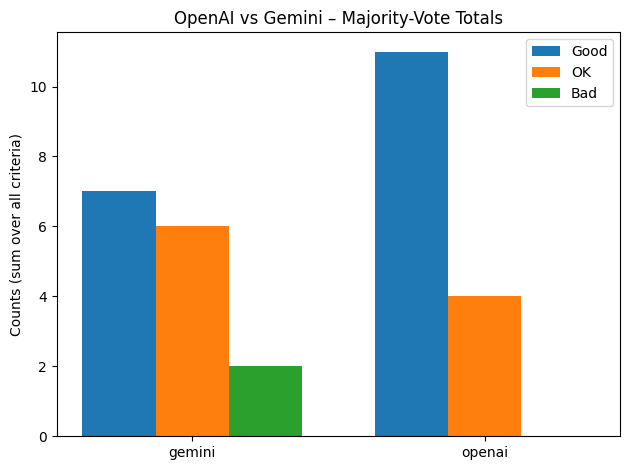

In [116]:
import matplotlib.pyplot as plt

# Aggregate Good/OK/Bad sums per backend
agg = df_long.groupby("backend")[["good","ok","bad"]].sum().reset_index()

plt.figure()
x = range(len(agg))
w = 0.25
plt.bar([xi - w for xi in x], agg["good"], width=w, label="Good")
plt.bar(x, agg["ok"], width=w, label="OK")
plt.bar([xi + w for xi in x], agg["bad"], width=w, label="Bad")
plt.xticks(list(x), agg["backend"])
plt.ylabel("Counts (sum over all criteria)")
plt.title("OpenAI vs Gemini – Majority-Vote Totals")
plt.legend()
plt.tight_layout()
plt.show()


## 7 *(Bonus)* Dataset‑Level Majority‑Vote Evaluation

You have a row‑level ensemble grader (`majority_vote_jlm`) that produces a more
stable verdict for **one** product description.  
In this bonus section you’ll **scale** that ensemble to an entire DataFrame so
you can compute dataset‑level metrics.

### Goals

1. **Automate majority voting across the dataset**: run `majority_vote_jlm`
   *n* times per description and store the combined verdicts/explanations.  
2. **Reuse your scoring pipeline**: pipe the enriched DataFrame through
   `apply_final_scoring` to get a `final_label`.  
3. **Compare**: how do the label distributions differ from the single‑judge
   evaluation in Section 5?

> *Extra credit*: add timing & cost tracking so you can quantify the trade‑off.

In [ ]:
# ------------------------- BONUS TODO -------------------------
import pandas as pd

def judge_dataframe_mv(df: pd.DataFrame, n: int = 3) -> pd.DataFrame:
    """Run majority‑vote JLM `n` times per description and return enriched DF."""
    rows = []
    for _, row in df.iterrows():
        desc = row["description"]
        result = majority_vote_jlm(desc, n=n)
        flat = row.to_dict()
        for crit, vals in result.items():
            flat[f"{crit}_explanation"] = vals["explanation"]
            flat[f"{crit}_verdict"] = vals["verdict"]
        rows.append(flat)
    return pd.DataFrame(rows)

# Example workflow:
# df_mv = judge_dataframe_mv(df_input, n=5)
# df_mv_scored = apply_final_scoring(df_mv, judgement_guidelines)
# print(df_mv_scored['final_label'].value_counts())
# ---------------------------------------------------------------
